In [1]:
import numpy as np
import re
import csv
import tqdm
import time

import pdb


np_load_old = np.load

# Define a modified np.load function with allow_pickle=True by default
def np_load_modified(*args, **kwargs):
    kwargs['allow_pickle'] = True
    return np_load_old(*args, **kwargs)

# Set np.load to the modified function
np.load = np_load_modified

In [2]:
dataset_50 = np.load("/kaggle/input/lyrics-dataset-v3/dataset_50_v3.npy")

melody = dataset_50[0]
lyrics = dataset_50[1]
labels = dataset_50[2]

with_labels_id = []
for i in range(labels.shape[0]):
    if labels[i] != 'unlabelled':
        with_labels_id.append(i)

dataset_50_group = dataset_50[:, with_labels_id]
num = dataset_50_group.shape[1]
lenth = num // 8
print(num, lenth)
new_dataset = []
for i in range(8):
    new_dataset.append(dataset_50_group[:, (i*lenth):((i*lenth)+lenth)])
dataset_50_group_8 = np.array(new_dataset)
np.save("/kaggle/working/dataset_50_v3_clf.npy", dataset_50_group_8)



27898 3487


In [3]:
dataset_sample = np.load("/kaggle/working/dataset_50_v3_clf.npy")

# ***Training the music emotion classifier***

**Using Transfomer to Classify**

In [4]:
from gensim.models import Word2Vec
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch
import os
import pandas as pd
import pickle
import torch.optim as optim
import torch.nn as nn
import argparse
from torch.autograd import Variable
import pdb

In [5]:
# -*- coding: utf-8 -*-


def adjust_learning_rate(optimizer, epoch):
    lr = opt.learning_rate * (0.1 ** (epoch // 10))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

class TxtDatasetProcessing(Dataset):
    def __init__(self, dataset, seqlen, syllable_vocabulary, music_vocabulary):
        self.dataset = dataset
        lyrics = []
        musics = []
        labels = []
        for i in range(dataset.shape[0]):
            musics += list(dataset[i, 0, :])
            lyrics += list(dataset[i, 1, :])
            labels += list(dataset[i, 2, :]) 

        index = []
        for i in range(len(labels)):
            if labels[i] == 'negative':
                index.append(i)
        
        negative_musics = []
        negative_lyrics = []
        negative_labels = []
        for i in index:
            negative_musics.append(musics[i])
            negative_lyrics.append(lyrics[i])
            negative_labels.append(labels[i])

        self.lyrics = lyrics+negative_lyrics
        self.musics = musics+negative_musics
        self.labels = labels+negative_labels
        self.seqlen = seqlen
        self.word_vocabulary = word_vocabulary
        self.syllable_vocabulary = syllable_vocabulary
        self.music_vocabulary = music_vocabulary

    def __getitem__(self, index):
        lyric = self.lyrics[index]
        music = self.musics[index]
        la = self.labels[index]
        if la == 'positive':
            label = torch.ones(1)
        else:
            label = torch.zeros(1)

        #txt = torch.zeros((seqlen, 23), dtype = torch.float64)
        txt = torch.LongTensor(np.zeros(self.seqlen, dtype=np.int64))
        mus = torch.LongTensor(np.zeros(self.seqlen, dtype=np.int64))
        txt_len = 0
        for i in range(len(lyric)):
            word = ''
            for syll in lyric[i]:
                word += syll
            if word in self.word_vocabulary:
                word2idx = self.word_vocabulary[word]
            else:
            	continue
            for j in range(len(lyric[i])):
                syll = lyric[i][j]
                #note = music[i][j]
                if syll in self.syllable_vocabulary:
                    syll2idx = self.syllable_vocabulary[syll]
                else:
                    continue
                #syllWordVec = (syll,word,note)
                music_note = 'p_'+str(music[i][j][0])+'^'+'d_'+str(music[i][j][1])+'^'+'r_'+str(music[i][j][2])
                if music_note in self.music_vocabulary:
                    music_note2idx = self.music_vocabulary[music_note]
                else:
                    continue
                syllWordVec = (syll2idx,music_note2idx)
                if txt_len<self.seqlen:
                    txt[txt_len] = syll2idx
                    mus[txt_len] = music_note2idx
                    txt_len += 1
                else:
                    break
            if txt_len >= self.seqlen:
                break
        return txt, mus, label.type(torch.int64)

    def __len__(self):
        return len(self.labels)

class TransformerClassifier(nn.Module):

    def __init__(self, input_txt_size, input_mus_size, nhead, num_layers, num_classes, syllable_vocabulary, music_vocabulary):
        super(TransformerClassifier, self).__init__()
        self.nhead = nhead
        self.num_layers = num_layers
        input_size = input_txt_size+input_mus_size
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_size, nhead=8, batch_first=True)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=self.num_layers)
        self.fc = nn.Linear(input_size, num_classes)
        syllable_vocab_size = len(syllable_vocabulary)
        self.word_embeddings = nn.Embedding(syllable_vocab_size, input_txt_size)
        music_vocab_size = len(music_vocabulary)
        self.music_embeddings = nn.Embedding(music_vocab_size, input_mus_size)

    def forward(self, txt, mus):
        txt = self.word_embeddings(txt)
        mus = self.music_embeddings(mus)
        X = torch.cat((txt, mus), 2)
        Y = self.encoder(X)
        out = torch.mean(Y, dim=1)
        out = self.fc(out)
        return out

if __name__ == "__main__":
    
#     parser = argparse.ArgumentParser(description='CLF.py')
#     parser.add_argument('--data', type=str, default='/kaggle/working/dataset_50_v3_clf.npy', help="Dnd data.")
#     parser.add_argument('--dataset_len', type=str, default=50)
#     parser.add_argument('--batch_size', type=str, default=32)
#     parser.add_argument('--seqlen', type=str, default=70)
#     parser.add_argument('--learning_rate', type=str, default=0.0001)
#     parser.add_argument('--num_epochs', type=str, default=30)
#     opt = parser.parse_args()
    class Args:
        data = '/kaggle/working/dataset_50_v3_clf.npy'
        dataset_len = 50
        batch_size = 32
        seqlen = 70
        learning_rate = 0.0001
        num_epochs = 10
    opt = Args()
#     dataset_path = opt.data
#     data_to_process = np.load(dataset_path)
#     print(data_to_process)
   
    #dataset_len = 20
    #batch_size = 64
    #seqlen = 30
    #learning_rate = 0.0001
    #num_epochs = 30
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    # Load dataset
    dataset = np.load(opt.data)  
#     print(dataset)
    # Load other files with modified np.load
    word_vocabulary_file = '/kaggle/input/saved-model/word_vocabulary.npy'
    word_vocabulary = np.load(word_vocabulary_file)
    word_vocabulary = word_vocabulary.item()

    syllable_vocabulary_file = '/kaggle/input/saved-model/syllable_vocabulary.npy'
    syllable_vocabulary = np.load(syllable_vocabulary_file)
    syllable_vocabulary = syllable_vocabulary.item()

    music_vocabulary_file = '/kaggle/input/saved-model/music_vocabulary_'+str(opt.dataset_len)+'.npy'
    music_vocabulary = np.load(music_vocabulary_file)
    music_vocabulary = music_vocabulary.item()
    model = TransformerClassifier(input_txt_size=118, input_mus_size=10, nhead=8, num_layers=6, num_classes=2, syllable_vocabulary=syllable_vocabulary, music_vocabulary=music_vocabulary)
    model = model.to(device)

    for i in range(1):
        train_dataset = np.concatenate((dataset[0:i], dataset[i+1:]), axis=0)
        test_dataset = dataset[i:i+1]

        dtrain_set = TxtDatasetProcessing(train_dataset, opt.seqlen, syllable_vocabulary, music_vocabulary)
        train_loader = DataLoader(dtrain_set, batch_size=opt.batch_size, shuffle=True, num_workers=4)
        
        # data[0] torch.Size([64, 30])  data[1] torch.Size([64, 30])   data[2] torch.Size([64, 1])
        #for data in train_loader:
        #    print(data)

        dtest_set = TxtDatasetProcessing(test_dataset, opt.seqlen, syllable_vocabulary, music_vocabulary)
        test_loader = DataLoader(dtrain_set, batch_size=opt.batch_size, shuffle=True, num_workers=4)

        optimizer = optim.Adam(model.parameters(), lr=opt.learning_rate)
        loss_function = nn.CrossEntropyLoss()
        train_loss_ = []
        test_loss_ = []
        train_acc_ = []
        test_acc_ = []

        for epoch in range(opt.num_epochs):
            optimizer = adjust_learning_rate(optimizer, epoch)
            total_acc = 0.0
            total_loss = 0.0
            total = 0.0
            for iter, traindata in enumerate(train_loader):
                train_txt, train_mus ,train_labels = traindata
                train_labels = torch.squeeze(train_labels)
                train_txt = Variable(train_txt.to(device))
                train_mus = Variable(train_mus.to(device))
                train_labels = Variable(train_labels.to(device))

                model.zero_grad()
                output = model(train_txt, train_mus)
                output = output.squeeze(dim=-1)

                loss = loss_function(output, Variable(train_labels))
                loss.backward()
                optimizer.step()

                _, predicted = torch.max(output.data, 1)
                total_acc += (predicted == train_labels).sum()
                total_acc = total_acc.type(torch.float32)
                total += torch.tensor(len(train_labels))
                total = total.type(torch.float32)
                total_loss += loss.data

            train_loss_.append(total_loss / total)
            train_acc_.append(total_acc / total)
            # testing epoch
            total_acc = 0.0
            total_loss = 0.0
            total = 0.0
            for iter, testdata in enumerate(test_loader):
                test_txt, test_mus, test_labels = testdata
                test_labels = torch.squeeze(test_labels)
                test_txt = Variable(test_txt.to(device))
                test_mus = Variable(test_mus.to(device))
                test_labels = Variable(test_labels.to(device))

                output = model(test_txt, test_mus)
                output = output.squeeze(dim=-1)

                loss = loss_function(output, Variable(test_labels))

                # calc testing acc
                _, predicted = torch.max(output.data, 1)

                #predicted = 1*(output>0.5)
                total_acc += (predicted == test_labels).sum()
                total_acc = total_acc.type(torch.float32)
                total += torch.tensor(len(test_labels))
                total = total.type(torch.float32)
                total_loss += loss.data

            test_loss_.append(total_loss / total)
            test_acc_.append(total_acc / total)
            print('[Epoch: %3d/%3d] Training Loss: %.3f, Testing Loss: %.3f, Training Acc: %.3f, Testing Acc: %.3f'
              % (epoch, opt.num_epochs, train_loss_[epoch], test_loss_[epoch], test_acc_[epoch], train_acc_[epoch]))

        filename = f'/kaggle/working/Transformer_datasetlen_{opt.dataset_len}_fold_{i}_clf.pkl'
        torch.save(model.state_dict(), filename)
        print('File %s is saved.' % filename)

[Epoch:   0/ 10] Training Loss: 0.019, Testing Loss: 0.015, Training Acc: 0.767, Testing Acc: 0.651
[Epoch:   1/ 10] Training Loss: 0.014, Testing Loss: 0.011, Training Acc: 0.850, Testing Acc: 0.799
[Epoch:   2/ 10] Training Loss: 0.010, Testing Loss: 0.007, Training Acc: 0.910, Testing Acc: 0.858
[Epoch:   3/ 10] Training Loss: 0.008, Testing Loss: 0.005, Training Acc: 0.941, Testing Acc: 0.903
[Epoch:   4/ 10] Training Loss: 0.005, Testing Loss: 0.004, Training Acc: 0.958, Testing Acc: 0.937
[Epoch:   5/ 10] Training Loss: 0.004, Testing Loss: 0.003, Training Acc: 0.971, Testing Acc: 0.955
[Epoch:   6/ 10] Training Loss: 0.003, Testing Loss: 0.002, Training Acc: 0.978, Testing Acc: 0.965
[Epoch:   7/ 10] Training Loss: 0.002, Testing Loss: 0.002, Training Acc: 0.985, Testing Acc: 0.974
[Epoch:   8/ 10] Training Loss: 0.002, Testing Loss: 0.001, Training Acc: 0.988, Testing Acc: 0.979
[Epoch:   9/ 10] Training Loss: 0.002, Testing Loss: 0.001, Training Acc: 0.987, Testing Acc: 0.980


**Using LSTM to CLassify**

In [6]:
from gensim.models import Word2Vec
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch
import os
import pandas as pd
import pickle
import torch.optim as optim
import torch.nn as nn
import argparse
from torch.autograd import Variable
import pdb

In [7]:
def adjust_learning_rate(optimizer, epoch):
    lr = opt.learning_rate * (0.1 ** (epoch // 10))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

class TxtDatasetProcessing(Dataset):
    def __init__(self, dataset, seqlen, syllable_vocabulary, music_vocabulary):
        self.dataset = dataset
        lyrics = []
        musics = []
        labels = []
        for i in range(dataset.shape[0]):
            musics += list(dataset[i, 0, :])
            lyrics += list(dataset[i, 1, :])
            labels += list(dataset[i, 2, :]) 

        #把negative samples记录下来，多两倍
        index = []
        for i in range(len(labels)):
            if labels[i] == 'negative':
                index.append(i)
        
        negative_musics = []
        negative_lyrics = []
        negative_labels = []
        for i in index:
            negative_musics.append(musics[i])
            negative_lyrics.append(lyrics[i])
            negative_labels.append(labels[i])

        self.lyrics = lyrics+negative_lyrics
        self.musics = musics+negative_musics
        self.labels = labels+negative_labels
        
        self.seqlen = seqlen
        self.word_vocabulary = word_vocabulary
        self.syllable_vocabulary = syllable_vocabulary
        self.music_vocabulary = music_vocabulary

    def __getitem__(self, index):
        lyric = self.lyrics[index]
        music = self.musics[index]
        la = self.labels[index]
        if la == 'positive':
            label = torch.ones(1)
        else:
            label = torch.zeros(1)

        #txt = torch.zeros((seqlen, 23), dtype = torch.float64)
        txt = torch.LongTensor(np.zeros(self.seqlen, dtype=np.int64))
        mus = torch.LongTensor(np.zeros(self.seqlen, dtype=np.int64))
        txt_len = 0
        for i in range(len(lyric)):
            word = ''
            for syll in lyric[i]:
                word += syll
            if word in self.word_vocabulary:
                word2idx = self.word_vocabulary[word]
            else:
            	continue

            for j in range(len(lyric[i])):
                syll = lyric[i][j]
                #note = music[i][j]
                if syll in self.syllable_vocabulary:
                    syll2idx = self.syllable_vocabulary[syll]
                else:
                    continue
                #syllWordVec = (syll,word,note)
                music_note = 'p_'+str(music[i][j][0])+'^'+'d_'+str(music[i][j][1])+'^'+'r_'+str(music[i][j][2])
                if music_note in self.music_vocabulary:
                    music_note2idx = self.music_vocabulary[music_note]
                else:
                    continue
                syllWordVec = (syll2idx,music_note2idx)
                if txt_len<self.seqlen:
                    txt[txt_len] = syll2idx
                    mus[txt_len] = music_note2idx
                    txt_len += 1
                else:
                    break
            if txt_len >= self.seqlen:
                break
        return txt, mus, label.type(torch.int64)

    def __len__(self):
        return len(self.labels)

class LSTMClassifier(nn.Module):

    def __init__(self, input_txt_size, input_mus_size, hidden_size, num_layers, num_classes, syllable_vocabulary, music_vocabulary):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        input_size = input_txt_size+input_mus_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)
        syllable_vocab_size = len(syllable_vocabulary)
        self.word_embeddings = nn.Embedding(syllable_vocab_size, input_txt_size)
        music_vocab_size = len(music_vocabulary)
        self.music_embeddings = nn.Embedding(music_vocab_size, input_mus_size)

    def forward(self, txt, mus):
        h0 = torch.zeros(self.num_layers*2, txt.size(0), self.hidden_size).cuda() 
        c0 = torch.zeros(self.num_layers*2, txt.size(0), self.hidden_size).cuda()
        lens = len(txt)
        batch_size = txt.size(0)
        txt = self.word_embeddings(txt)
        mus = self.music_embeddings(mus)
        X = torch.cat((txt, mus), 2)

        out, _ = self.lstm(X, (h0, c0))  
        out = self.fc(out[:, -1, :])
        return out

if __name__ == "__main__":
#     parser = argparse.ArgumentParser(description='CLF.py')
#     parser.add_argument('--data', type=str, default='lyrics_datasets_v3/dataset_50_v3_clf.npy', help="Dnd data.")
#     parser.add_argument('--dataset_len', type=str, default=50)
#     parser.add_argument('--batch_size', type=str, default=32)
#     parser.add_argument('--seqlen', type=str, default=70)
#     parser.add_argument('--learning_rate', type=str, default=0.0001)
#     parser.add_argument('--num_epochs', type=str, default=30)
#     opt = parser.parse_args()
    class Args:
        data = '/kaggle/working/dataset_50_v3_clf.npy'
        dataset_len = 50
        batch_size = 32
        seqlen = 70
        learning_rate = 0.0001
        num_epochs = 10
    opt = Args()
    #dataset_len = 20
    #batch_size = 64
    #seqlen = 30
    #learning_rate = 0.0001
    #num_epochs = 30
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    dataset = np.load(opt.data) #shape (8, 4, 4722)
#     print(dataset)

    word_vocabulary_file = '/kaggle/input/saved-model/word_vocabulary.npy'
    word_vocabulary = np.load(word_vocabulary_file)
    word_vocabulary = word_vocabulary.item()
    syllable_vocabulary_file = '/kaggle/input/saved-model/syllable_vocabulary.npy'
    syllable_vocabulary = np.load(syllable_vocabulary_file)
    syllable_vocabulary = syllable_vocabulary.item()
    music_vocabulary_file = '/kaggle/input/saved-model/music_vocabulary_'+str(opt.dataset_len)+'.npy'
    music_vocabulary = np.load(music_vocabulary_file)
    music_vocabulary = music_vocabulary.item()

    model = LSTMClassifier(input_txt_size=128, input_mus_size=10, hidden_size=256, num_layers=6, num_classes=2, syllable_vocabulary=syllable_vocabulary, music_vocabulary=music_vocabulary)
    model = model.to(device)

    for i in range(1):
        train_dataset = np.concatenate((dataset[0:i], dataset[i+1:]), axis=0)
        test_dataset = dataset[i:i+1]

        dtrain_set = TxtDatasetProcessing(train_dataset, opt.seqlen, syllable_vocabulary, music_vocabulary)
        train_loader = DataLoader(dtrain_set, batch_size=opt.batch_size, shuffle=True, num_workers=4)
        
        # data[0] torch.Size([64, 30])  data[1] torch.Size([64, 30])   data[2] torch.Size([64, 1])
        #for data in train_loader:
        #    print(data)

        dtest_set = TxtDatasetProcessing(test_dataset, opt.seqlen, syllable_vocabulary, music_vocabulary)
        test_loader = DataLoader(dtrain_set, batch_size=opt.batch_size, shuffle=True, num_workers=4)

        optimizer = optim.Adam(model.parameters(), lr=opt.learning_rate)
        loss_function = nn.CrossEntropyLoss()
        train_loss_ = []
        test_loss_ = []
        train_acc_ = []
        test_acc_ = []

        for epoch in range(opt.num_epochs):
            optimizer = adjust_learning_rate(optimizer, epoch)
            total_acc = 0.0
            total_loss = 0.0
            total = 0.0
            for iter, traindata in enumerate(train_loader):
                train_txt, train_mus ,train_labels = traindata
                train_labels = torch.squeeze(train_labels)
                train_txt = Variable(train_txt.to(device))
                train_mus = Variable(train_mus.to(device))
                train_labels = Variable(train_labels.to(device))

                model.zero_grad()
                output = model(train_txt, train_mus)
                output = output.squeeze(dim=-1)

                loss = loss_function(output, Variable(train_labels))
                loss.backward()
                optimizer.step()

                _, predicted = torch.max(output.data, 1)
                total_acc += (predicted == train_labels).sum()
                total_acc = total_acc.type(torch.float32)
                total += torch.tensor(len(train_labels))
                total = total.type(torch.float32)
                total_loss += loss.data

            train_loss_.append(total_loss / total)
            train_acc_.append(total_acc / total)
            # testing epoch
            total_acc = 0.0
            total_loss = 0.0
            total = 0.0
            for iter, testdata in enumerate(test_loader):
                test_txt, test_mus, test_labels = testdata
                test_labels = torch.squeeze(test_labels)
                test_txt = Variable(test_txt.to(device))
                test_mus = Variable(test_mus.to(device))
                test_labels = Variable(test_labels.to(device))

                output = model(test_txt, test_mus)
                output = output.squeeze(dim=-1)

                loss = loss_function(output, Variable(test_labels))

                # calc testing acc
                _, predicted = torch.max(output.data, 1)

                #predicted = 1*(output>0.5)
                total_acc += (predicted == test_labels).sum()
                total_acc = total_acc.type(torch.float32)
                total += torch.tensor(len(test_labels))
                total = total.type(torch.float32)
                total_loss += loss.data

            test_loss_.append(total_loss / total)
            test_acc_.append(total_acc / total)
            print('[Epoch: %3d/%3d] Training Loss: %.3f, Testing Loss: %.3f, Training Acc: %.3f, Testing Acc: %.3f'
              % (epoch, opt.num_epochs, train_loss_[epoch], test_loss_[epoch], train_acc_[epoch], test_acc_[epoch]))

        filename = '/kaggle/working/LSTM_datasetlen_' + str(opt.dataset_len) + '_fold_' + str(i) + '_clf.pkl'
        torch.save(model.state_dict(), filename)
        print('File %s is saved.' % filename)

[Epoch:   0/ 10] Training Loss: 0.021, Testing Loss: 0.021, Training Acc: 0.606, Testing Acc: 0.551
[Epoch:   1/ 10] Training Loss: 0.019, Testing Loss: 0.018, Training Acc: 0.675, Testing Acc: 0.716
[Epoch:   2/ 10] Training Loss: 0.017, Testing Loss: 0.015, Training Acc: 0.736, Testing Acc: 0.769
[Epoch:   3/ 10] Training Loss: 0.015, Testing Loss: 0.014, Training Acc: 0.786, Testing Acc: 0.806
[Epoch:   4/ 10] Training Loss: 0.013, Testing Loss: 0.011, Training Acc: 0.825, Testing Acc: 0.857
[Epoch:   6/ 10] Training Loss: 0.008, Testing Loss: 0.007, Training Acc: 0.893, Testing Acc: 0.921
[Epoch:   7/ 10] Training Loss: 0.007, Testing Loss: 0.005, Training Acc: 0.921, Testing Acc: 0.946
[Epoch:   8/ 10] Training Loss: 0.005, Testing Loss: 0.005, Training Acc: 0.938, Testing Acc: 0.932
[Epoch:   9/ 10] Training Loss: 0.004, Testing Loss: 0.004, Training Acc: 0.951, Testing Acc: 0.965
File /kaggle/working/LSTM_datasetlen_50_fold_0_clf.pkl is saved.


# ***Training the lyric and melody generator***

**Using Transformer for Generating lyrics and melody**

In [8]:
from gensim.models import Word2Vec
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torch
import os
import pandas as pd
import pickle
import torch.optim as optim
import torch.nn as nn
import argparse
from torch.autograd import Variable
from collections import Counter
import math
import torch.nn.functional as F
from torch.nn import Transformer
import pdb

In [9]:
def adjust_learning_rate(optimizer, epoch, learning_rate):
    lr = learning_rate * (0.1 ** (epoch // 10))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

class myTransformer(Transformer):
    def forward(self, src, tgt, src_mask = None, tgt_mask = None,
                memory_mask = None, src_key_padding_mask = None,
                tgt_key_padding_mask = None, memory_key_padding_mask = None):
        if not self.batch_first and src.size(1) != tgt.size(1):
            raise RuntimeError("the batch number of src and tgt must be equal")
        elif self.batch_first and src.size(0) != tgt.size(0):
            raise RuntimeError("the batch number of src and tgt must be equal")
        if src.size(2) != self.d_model or tgt.size(2) != self.d_model:
            raise RuntimeError("the feature number of src and tgt must be equal to d_model")

        memory = self.encoder(src, mask=src_mask, src_key_padding_mask=src_key_padding_mask)
        output = self.decoder(tgt, memory, tgt_mask=tgt_mask, memory_mask=memory_mask,
                              tgt_key_padding_mask=tgt_key_padding_mask,
                              memory_key_padding_mask=memory_key_padding_mask)
        return memory, output #encoder output and decoder output

class Transformer_seq2seq(nn.Module):
    def __init__(self, transformer_model, dim, lyric_vocabulary, music_vocabulary):
        super().__init__()
        self.transformer_model = transformer_model
        self.dim = dim
        self.lyric_vocabulary=lyric_vocabulary
        self.music_vocabulary=music_vocabulary
        self.lyric_vocab = len(lyric_vocabulary)
        self.music_vocab = len(music_vocabulary)
        self.fc_lyric = nn.Linear(self.dim, self.lyric_vocab)
        self.fc_music = nn.Linear(self.dim, self.music_vocab)
        self.music_embedding = nn.Embedding(num_embeddings=self.music_vocab,embedding_dim=self.dim)

    def forward(self, src, tgt):
        tgt = self.music_embedding(tgt) #torch.Size([64, 19, 256])
        en_hi, de_hi = self.transformer_model(src, tgt) #torch.Size([64, 19, 256])
        en_output = self.fc_lyric(en_hi) #torch.Size([64, 19, 20934])
        de_output = self.fc_music(de_hi) 

        return en_output, de_output

class TxtDatasetProcessing(Dataset):
    def __init__(self, dataset, syllModel, wordModel, seqlen, lyc2vec, music_vocabulary):
        self.dataset = dataset

        lyrics = list(dataset[1])
        musics = list(dataset[0])
        labels = list(dataset[2])

        index = []
        for i in range(len(labels)):
            if labels[i] == 'negative':
                index.append(i)
        
        negative_musics = []
        negative_lyrics = []
        negative_labels = []
        for i in index:
            negative_musics.append(musics[i])
            negative_lyrics.append(lyrics[i])
            negative_labels.append(labels[i])

        self.lyrics = lyrics+negative_lyrics
        self.musics = musics+negative_musics
        self.labels = labels+negative_labels

        self.syllModel = syllModel
        self.wordModel = wordModel
        self.seqlen = seqlen
        self.lyc2vec = lyc2vec
        self.music_vocabulary = music_vocabulary

    def __getitem__(self, index):
        lyric = self.lyrics[index]
        music = self.musics[index]

        lyric_input = torch.zeros((self.seqlen-1, self.lyc2vec*2), dtype = torch.float64)
        lyric_label = torch.LongTensor(np.zeros(self.seqlen-1, dtype=np.int64))

        music_input = torch.LongTensor(np.zeros(self.seqlen-1, dtype=np.int64))
        music_label = torch.LongTensor(np.zeros(self.seqlen-1, dtype=np.int64))

        word_input = torch.LongTensor(np.zeros(self.seqlen-1, dtype=np.int64))
        syll_input = torch.LongTensor(np.zeros(self.seqlen-1, dtype=np.int64))

        txt_len = 0
        for i in range(len(lyric)):
            word = ''
            for syll in lyric[i]:
                word += syll
            if word in self.wordModel.wv.index_to_key:
                word2Vec = self.wordModel.wv[word]
                word2idx = self.wordModel.wv.key_to_index[word]
            else:
                continue
            for j in range(len(lyric[i])):
                syll = lyric[i][j]
                note = 'p_'+str(music[i][j][0])+'^'+'d_'+str(music[i][j][1])+'^'+'r_'+str(music[i][j][2])
                note2idx = self.music_vocabulary[note]
                if syll in self.syllModel.wv.index_to_key:
                    syll2Vec = self.syllModel.wv[syll]
                    syll2idx = self.syllModel.wv.key_to_index[syll]
                else:
                    continue
                syllWordVec = np.concatenate((word2Vec,syll2Vec))
                if txt_len<self.seqlen-1:
                    lyric_input[txt_len] = torch.from_numpy(syllWordVec)
                    word_input[txt_len] = word2idx
                    syll_input[txt_len] = syll2idx
                    music_input[txt_len] = note2idx
                if txt_len<self.seqlen and txt_len>0:
                    lyric_label[txt_len-1] = syll2idx
                    music_label[txt_len-1] = note2idx
                txt_len += 1

            if txt_len >= self.seqlen:
                break
            if txt_len >= self.seqlen:
                break
        # word_input.type(torch.int64), syll_input.type(torch.int64), 
        return lyric_input.type(torch.float32), lyric_label.type(torch.int64), music_input.type(torch.int64), music_label.type(torch.int64)

    def __len__(self):
        return len(self.lyrics)

if __name__ == "__main__":
#     parser = argparse.ArgumentParser(description='lyrics_melody_generator.py')
#     parser.add_argument('--data', type=str, default='/kaggle/input/lyrics-dataset-v3/dataset_50_v3.npy', help="Dnd data.")
#     parser.add_argument('--batch_size', type=str, default=32, help="batch size")
#     parser.add_argument('--seqlen', type=str, default=50, help="seqlen")
#     parser.add_argument('--learning_rate', type=str, default=0.0001, help="learning rate")
#     parser.add_argument('--num_epochs', type=str, default=60, help="num pochs")
#     parser.add_argument('--lyc2vec', type=str, default=128, help="num pochs")
#     opt = parser.parse_args()
    
    class Args:
        data = '/kaggle/input/lyrics-dataset-v3/dataset_50_v3.npy'
        batch_size = 32
        seqlen = 50
        learning_rate = 0.0001
        num_epochs = 1
        lyc2vec = 128

    opt = Args()


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#     # save np.load
#     np_load_old = np.load

#     # modify the default parameters of np.load
#     np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

    dataset = np.load(opt.data)

    syll_model_path = '/kaggle/input/skip-gram-lyric-encoders/syllEncoding_skipgram_dim_128.bin'
    word_model_path = '/kaggle/input/skip-gram-lyric-encoders/wordLevelEncoder_skipgram_dim_128.bin'
    syllModel = Word2Vec.load(syll_model_path)
    wordModel = Word2Vec.load(word_model_path)

    lyric_vocabulary = syllModel.wv
    #music_vocabulary = build_vocabulary(dataset) #len=6064
    music_vocabulary_file = '/kaggle/input/saved-model/music_vocabulary_'+str(opt.seqlen)+'.npy'
    music_vocabulary = np.load(music_vocabulary_file)
    music_vocabulary = music_vocabulary.item()

    dtrain_set = TxtDatasetProcessing(dataset, syllModel, wordModel, opt.seqlen, opt.lyc2vec, music_vocabulary)
    #data = dtrain_set[0] torch.Size([19, 256]) torch.Size([19]) torch.Size([19]) torch.Size([19])
    train_loader = DataLoader(dtrain_set, batch_size=opt.batch_size, shuffle=True, drop_last=True, num_workers=4)
    for data in train_loader:
        lyric_input, lyric_label, music_input, music_label = data
        break
        #torch.Size([64, 19, 256]) torch.Size([64, 19])

    transformer_model = myTransformer(d_model=opt.lyc2vec*2, nhead=16, num_encoder_layers=12, num_decoder_layers=12, batch_first=True)
    model = Transformer_seq2seq(transformer_model=transformer_model, dim = opt.lyc2vec*2, lyric_vocabulary=lyric_vocabulary, music_vocabulary=music_vocabulary)
    model = model.to(device)
    
    #out = transformer_model(src, tgt) #torch.Size([64, 19, 256]) torch.Size([64, 19, 256])

    #encoder = Encoder(input_size=opt.lyc2vec*2, hidden_size=256, num_layers=4, vocabulary=lyric_vocabulary).to(device)
    #decoder = Decoder(embedding_dim=100, hidden_size=256, num_layers=4, vocabulary=music_vocabulary).to(device)

    #model = Seq2Seq(encoder, decoder).to(device)
    #model.apply(init_weights)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=opt.learning_rate)
    softmax = nn.Softmax(dim=0)
    train_losses = []

    for epoch in range(opt.num_epochs):
        model.train()
        optimizer = adjust_learning_rate(optimizer, epoch, opt.learning_rate)
        for iter, traindata in enumerate(train_loader):
            lyric_input, lyric_label, music_input, music_label = traindata
            lyric_input = Variable(lyric_input.to(device))
            lyric_label = Variable(lyric_label.to(device))
            music_input = Variable(music_input.to(device))
            music_label = Variable(music_label.to(device))

            optimizer.zero_grad()

            en_pred, de_pred = model(lyric_input, music_input)

            #unlikelihood loss
            en_loss = 0
            for batch in range(opt.batch_size):
                en_pred_batch = en_pred[batch]
                lyric_label_batch = lyric_label[batch]
                for length in range(opt.seqlen-1):
                    logits = en_pred_batch[length]
                    prob = softmax(logits)
                    with torch.no_grad():
                        label = lyric_label_batch[length]
                        negative_samples = list(set(lyric_label_batch[:length].tolist()))
                    likelihood_loss = -1*torch.log(prob[label])
                    unlikelihood_loss = 0
                    if negative_samples:
                        #for ns in negative_samples:
                        unlikelihood_loss = (-1*torch.log(1-prob[negative_samples])).mean()
                        #unlikelihood_loss /= len(negative_samples)
                    en_loss += (likelihood_loss+unlikelihood_loss)
            en_loss /= (opt.batch_size*(opt.seqlen-1))

            #en_dim = en_pred.shape[-1]
            de_dim = de_pred.shape[-1]
            #en_pred = en_pred.view(-1, en_dim)
            de_pred = de_pred.view(-1, de_dim)
            #lyric_label = lyric_label.reshape(-1)
            music_label = music_label.reshape(-1)
            #en_loss = criterion(en_pred, lyric_label)
            de_loss = criterion(de_pred, music_label)
            loss = en_loss + de_loss

            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

            if iter % 100 == 0:
                print({ 'epoch': epoch, 'batch': iter, 'loss': loss.item()})
                #filename = 'Transformer_generator_'+'iter_'+str(iter)+'_epoch_'+str(epoch)+'.pkl'
                #torch.save(model.state_dict(), filename)
                #print('File %s is saved.' % filename)

        # Define the filename with the full path to the Kaggle working directory
        filename = '/kaggle/working/Transformer_generator_seqlen_' + str(opt.seqlen) + '_embed_' + str(opt.lyc2vec) + '_epoch_' + str(epoch) + '.pkl'
        torch.save(model.state_dict(), filename)
        print('File %s is saved.' % filename)

{'epoch': 0, 'batch': 0, 'loss': 19.24038314819336}
{'epoch': 0, 'batch': 100, 'loss': 12.028097152709961}
{'epoch': 0, 'batch': 200, 'loss': 10.897401809692383}
{'epoch': 0, 'batch': 300, 'loss': 10.674236297607422}
{'epoch': 0, 'batch': 400, 'loss': 10.329967498779297}
{'epoch': 0, 'batch': 500, 'loss': 10.217174530029297}
{'epoch': 0, 'batch': 600, 'loss': 9.982177734375}
{'epoch': 0, 'batch': 700, 'loss': 10.480854034423828}
{'epoch': 0, 'batch': 800, 'loss': 9.575637817382812}
{'epoch': 0, 'batch': 900, 'loss': 9.810836791992188}
{'epoch': 0, 'batch': 1000, 'loss': 9.397480964660645}
{'epoch': 0, 'batch': 1100, 'loss': 9.1319580078125}
{'epoch': 0, 'batch': 1200, 'loss': 9.613511085510254}
{'epoch': 0, 'batch': 1300, 'loss': 9.072336196899414}
{'epoch': 0, 'batch': 1400, 'loss': 8.692310333251953}
{'epoch': 0, 'batch': 1500, 'loss': 8.737483024597168}
{'epoch': 0, 'batch': 1600, 'loss': 8.370235443115234}
File /kaggle/working/Transformer_generator_seqlen_50_embed_128_epoch_0.pkl i

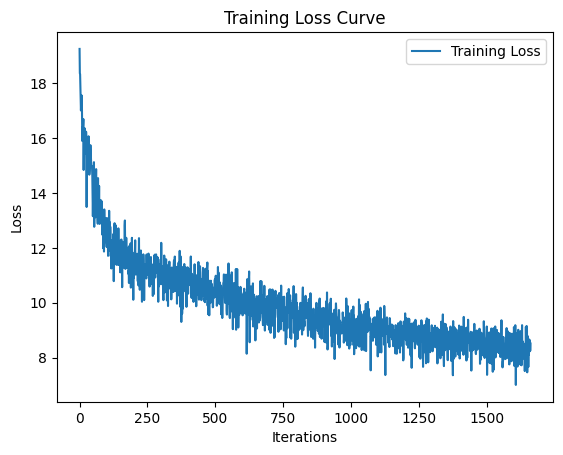

In [10]:
import matplotlib.pyplot as plt

# Plot the loss curve
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()


**Using Gated Recurrent Unit (GRU) for generating lyrics and melody**

In [11]:
from gensim.models import Word2Vec
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torch
import os
import pandas as pd
import pickle
import torch.optim as optim
import torch.nn as nn
import argparse
from torch.autograd import Variable
from collections import Counter
import math
import torch.nn.functional as F
import pdb

In [12]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, vocabulary):
        super(Encoder, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocabulary = vocabulary

        self.n_vocab = len(vocabulary)

        self.gru = nn.GRU(input_size=self.input_size, hidden_size=self.hidden_size,num_layers=self.num_layers,dropout=0.2,)
        self.fc = nn.Linear(self.hidden_size, self.n_vocab)

    def forward(self, x, prev_state):
    	#x: seqlen, batch_size, embed_dim
        states, hidden = self.gru(x, prev_state) #states: seqlen, batch_size, hidden_size 
        #hidden: num_layers, batch_size, hidden_size

        logits = self.fc(states) #seqlen, batch_size, vocab_dim

        return logits, hidden, states

    def init_state(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size))
                #torch.zeros(self.num_layers, sequence_length, self.hidden_size))

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))
        stdv = 1. / math.sqrt(self.v.size(0))
        self.v.data.uniform_(-stdv, stdv)

    def forward(self, hidden, encoder_outputs):
        timestep = encoder_outputs.size(0)
        h = hidden.repeat(timestep, 1, 1).transpose(0, 1)
        encoder_outputs = encoder_outputs.transpose(0, 1)  # [B*T*H]
        attn_energies = self.score(h, encoder_outputs)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

    def score(self, hidden, encoder_outputs):
        # [B*T*2H]->[B*T*H]
        energy = F.relu(self.attn(torch.cat([hidden, encoder_outputs], 2)))
        energy = energy.transpose(1, 2)  # [B*H*T]
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)  # [B*1*H]
        energy = torch.bmm(v, energy)  # [B*1*T]
        return energy.squeeze(1)  # [B*T]

class Decoder(nn.Module):
    def __init__(self, embedding_dim, hidden_size, num_layers, vocabulary):
        super().__init__()

        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocabulary = vocabulary
        self.n_vocab = len(vocabulary)
        
        self.embedding = nn.Embedding(num_embeddings=self.n_vocab,embedding_dim=self.embedding_dim)
        self.attention = Attention(self.hidden_size)
        
        self.gru = nn.GRU(input_size=self.embedding_dim+self.hidden_size, hidden_size=self.hidden_size,num_layers=self.num_layers,dropout=0.2)
        self.fc = nn.Linear(self.hidden_size*2, self.n_vocab)
    def forward(self, input, last_hidden, encoder_outputs):
        # Get the embedding of the current input word (last output word)
        embedded = self.embedding(input).unsqueeze(0)  # (1,B,N)
        #embedded = self.dropout(embedded)
        # Calculate attention weights and apply to encoder outputs
        attn_weights = self.attention(last_hidden[-1], encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))  # (B,1,N)
        context = context.transpose(0, 1)  # (1,B,N)
        # Combine embedded input word and attended context, run through RNN
        rnn_input = torch.cat([embedded, context], 2)
        output, hidden = self.gru(rnn_input, last_hidden)
        output = output.squeeze(0)  # (1,B,N) -> (B,N)
        context = context.squeeze(0)
        output = self.fc(torch.cat([output, context], 1))
        return output, hidden, attn_weights

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        assert encoder.hidden_size == decoder.hidden_size, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.num_layers == decoder.num_layers, \
            "Encoder and decoder must have equal number of layers!"
    def forward(self, lyric_input, music_input, en_state_h):
        #en_state_h, en_state_c = self.encoder.init_state(self.seqlen)
        #en_pred: seqlen, batch size, vocab size
        #en_state_h: num layers, batch size, hidden size
        #states: seqlen, batch size, hidden size
        en_pred, en_state_h, en_states = self.encoder(lyric_input, en_state_h)
        hidden = en_state_h

        de_pred = Variable(torch.zeros(music_input.size(0), music_input.size(1), self.decoder.n_vocab)).cuda()
        for t in range(music_input.size(0)):
            inputw = Variable(music_input[t, :])
            output, hidden, attn_weights = self.decoder(inputw, hidden, en_states)
            de_pred[t] = output
        #de_pred = self.decoder(music_input, en_state_h)
        return en_pred, de_pred, en_state_h

def adjust_learning_rate(optimizer, epoch, learning_rate):
    lr = learning_rate * (0.1 ** (epoch // 10))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

class TxtDatasetProcessing(Dataset):
    def __init__(self, dataset, syllModel, wordModel, seqlen, lyc2vec, music_vocabulary):
        self.dataset = dataset
        
        lyrics = list(dataset[1])
        musics = list(dataset[0])
        labels = list(dataset[2])

        index = []
        for i in range(len(labels)):
            if labels[i] == 'negative':
                index.append(i)
        
        negative_musics = []
        negative_lyrics = []
        negative_labels = []
        for i in index:
            negative_musics.append(musics[i])
            negative_lyrics.append(lyrics[i])
            negative_labels.append(labels[i])

        self.lyrics = lyrics+negative_lyrics
        self.musics = musics+negative_musics
        self.labels = labels+negative_labels

        self.syllModel = syllModel
        self.wordModel = wordModel
        self.seqlen = seqlen
        self.lyc2vec = lyc2vec
        self.music_vocabulary = music_vocabulary

    def __getitem__(self, index):
        lyric = self.lyrics[index]
        music = self.musics[index]

        lyric_input = torch.zeros((self.seqlen-1, self.lyc2vec*2), dtype = torch.float64)
        lyric_label = torch.LongTensor(np.zeros(self.seqlen-1, dtype=np.int64))

        music_input = torch.LongTensor(np.zeros(self.seqlen-1, dtype=np.int64))
        music_label = torch.LongTensor(np.zeros(self.seqlen-1, dtype=np.int64))
        txt_len = 0
        for i in range(len(lyric)):
            word = ''
            for syll in lyric[i]:
                word += syll
            if word in wordModel.wv.index_to_key:
                word2Vec = wordModel.wv[word]
            else:
                continue
            for j in range(len(lyric[i])):
                syll = lyric[i][j]
                note = 'p_'+str(music[i][j][0])+'^'+'d_'+str(music[i][j][1])+'^'+'r_'+str(music[i][j][2])
                note2idx = self.music_vocabulary[note]
                if syll in syllModel.wv.index_to_key:
                    syll2Vec = syllModel.wv[syll]
                    syll2idx = syllModel.wv.key_to_index[syll]
                else:
                    continue
                syllWordVec = np.concatenate((word2Vec,syll2Vec))
                if txt_len<self.seqlen-1:
                    lyric_input[txt_len] = torch.from_numpy(syllWordVec)
                    music_input[txt_len] = note2idx
                if txt_len<self.seqlen and txt_len>0:
                    lyric_label[txt_len-1] = syll2idx
                    music_label[txt_len-1] = note2idx
                txt_len += 1

            if txt_len >= self.seqlen:
                break
            if txt_len >= self.seqlen:
                break
        return lyric_input.type(torch.float32), lyric_label.type(torch.int64), music_input.type(torch.int64), music_label.type(torch.int64)

    def __len__(self):
        return len(self.lyrics)

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

if __name__ == "__main__":
#     parser = argparse.ArgumentParser(description='lyrics_melody_generator.py')
#     parser.add_argument('--data', type=str, default='lyrics_datasets_v3/dataset_50_v3.npy', help="Dnd data.")
#     parser.add_argument('--batch_size', type=str, default=32, help="batch size")
#     parser.add_argument('--seqlen', type=str, default=50, help="seqlen")
#     parser.add_argument('--learning_rate', type=str, default=0.0001, help="learning rate")
#     parser.add_argument('--num_epochs', type=str, default=60, help="num pochs")
#     parser.add_argument('--lyc2vec', type=str, default=128, help="num pochs")
#     opt = parser.parse_args()

    class Args:
        data = '/kaggle/input/lyrics-dataset-v3/dataset_50_v3.npy'
        batch_size = 32
        seqlen = 50
        learning_rate = 0.0001
        num_epochs = 1
        lyc2vec = 128

    opt = Args()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#     # save np.load
#     np_load_old = np.load

#     # modify the default parameters of np.load
#     np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

    dataset = np.load(opt.data)

    syll_model_path = '/kaggle/input/skip-gram-lyric-encoders/syllEncoding_skipgram_dim_128.bin'
    word_model_path = '/kaggle/input/skip-gram-lyric-encoders/wordLevelEncoder_skipgram_dim_128.bin'
    syllModel = Word2Vec.load(syll_model_path)
    wordModel = Word2Vec.load(word_model_path)

    lyric_vocabulary = syllModel.wv.key_to_index
    #music_vocabulary = build_vocabulary(dataset) #len=6064
    music_vocabulary_file = '/kaggle/input/saved-model/music_vocabulary_'+str(opt.seqlen)+'.npy'
    music_vocabulary = np.load(music_vocabulary_file)
    music_vocabulary = music_vocabulary.item()

    dtrain_set = TxtDatasetProcessing(dataset, syllModel, wordModel, opt.seqlen, opt.lyc2vec, music_vocabulary)
    #data = dtrain_set[0] torch.Size([19, 256]) torch.Size([19]) torch.Size([19]) torch.Size([19])
    train_loader = DataLoader(dtrain_set, batch_size=opt.batch_size, shuffle=True, drop_last=True, num_workers=4)
    #for data in train_loader:
    #    print(data) torch.Size([64, 19, 256]) torch.Size([64, 19]) torch.Size([64, 19]) torch.Size([64, 19])
    encoder = Encoder(input_size=opt.lyc2vec*2, hidden_size=256, num_layers=4, vocabulary=lyric_vocabulary).to(device)
    decoder = Decoder(embedding_dim=100, hidden_size=256, num_layers=4, vocabulary=music_vocabulary).to(device)

    model = Seq2Seq(encoder, decoder).to(device)
    model.apply(init_weights)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=opt.learning_rate)
    softmax = nn.Softmax(dim=0)
    train_losses = []

    for epoch in range(opt.num_epochs):
        model.train()
        en_state_h = encoder.init_state(opt.batch_size)
        en_state_h = Variable(en_state_h.to(device))
        optimizer = adjust_learning_rate(optimizer, epoch, opt.learning_rate)
        for iter, traindata in enumerate(train_loader):
            lyric_input, lyric_label, music_input, music_label = traindata
            lyric_input = Variable(lyric_input.transpose(0, 1).to(device))
            lyric_label = Variable(lyric_label.transpose(0, 1).to(device))
            music_input = Variable(music_input.transpose(0, 1).to(device))
            music_label = Variable(music_label.transpose(0, 1).to(device))

            optimizer.zero_grad()
            #lyric_input: torch.Size([49, 32, 256]) 
            #music_input:torch.Size([49, 32]) 
            #en_state_h:torch.Size([4, 32, 256])
            en_pred, de_pred, en_state_h = model(lyric_input, music_input, en_state_h)

            #unlikelihood loss
            en_loss = 0
            en_pred = en_pred.transpose(0, 1)
            lyric_label = lyric_label.transpose(0, 1)
            for batch in range(opt.batch_size):
                en_pred_batch = en_pred[batch]
                lyric_label_batch = lyric_label[batch]
                for length in range(opt.seqlen-1):
                    logits = en_pred_batch[length]
                    prob = softmax(logits)
                    with torch.no_grad():
                        label = lyric_label_batch[length]
                        negative_samples = list(set(lyric_label_batch[:length].tolist()))
                    likelihood_loss = -1*torch.log(prob[label])
                    unlikelihood_loss = 0
                    if negative_samples:
                        #for ns in negative_samples:
                        unlikelihood_loss = (-1*torch.log(1-prob[negative_samples])).mean()
                        #unlikelihood_loss /= len(negative_samples)
                    en_loss += (likelihood_loss+unlikelihood_loss)
            en_loss /= (opt.batch_size*(opt.seqlen-1))

            #en_dim = en_pred.shape[-1]
            de_dim = de_pred.shape[-1]
            #en_pred = en_pred.view(-1, en_dim)
            de_pred = de_pred.view(-1, de_dim)
            #lyric_label = lyric_label.reshape(-1)
            music_label = music_label.reshape(-1)
            #en_loss = criterion(en_pred, lyric_label)
            de_loss = criterion(de_pred, music_label)

            loss = en_loss + de_loss

            loss.backward()
            optimizer.step()

            en_state_h = en_state_h.detach()
            train_losses.append(loss.item())
            if iter % 100 == 0:
                print({ 'epoch': epoch, 'batch': iter, 'loss': loss.item()})

        filename = '/kaggle/working/GRU_generator_seqlen_'+str(opt.seqlen)+'_embed_'+str(opt.lyc2vec)+'_epoch_'+str(epoch)+'.pkl'
        torch.save(model.state_dict(), filename)
        print('File %s is saved.' % filename)

{'epoch': 0, 'batch': 0, 'loss': 18.66602897644043}
{'epoch': 0, 'batch': 100, 'loss': 12.7371826171875}
{'epoch': 0, 'batch': 200, 'loss': 11.203845977783203}
{'epoch': 0, 'batch': 300, 'loss': 10.576912879943848}
{'epoch': 0, 'batch': 400, 'loss': 12.977043151855469}
{'epoch': 0, 'batch': 500, 'loss': 11.89743423461914}
{'epoch': 0, 'batch': 600, 'loss': 11.16193962097168}
{'epoch': 0, 'batch': 700, 'loss': 11.941011428833008}
{'epoch': 0, 'batch': 800, 'loss': 11.543895721435547}
{'epoch': 0, 'batch': 900, 'loss': 11.411401748657227}
{'epoch': 0, 'batch': 1000, 'loss': 11.653983116149902}
{'epoch': 0, 'batch': 1100, 'loss': 11.623109817504883}
{'epoch': 0, 'batch': 1200, 'loss': 11.611237525939941}
{'epoch': 0, 'batch': 1300, 'loss': 11.88296890258789}
{'epoch': 0, 'batch': 1400, 'loss': 11.008476257324219}
{'epoch': 0, 'batch': 1500, 'loss': 11.597939491271973}
{'epoch': 0, 'batch': 1600, 'loss': 11.885136604309082}
File /kaggle/working/GRU_generator_seqlen_50_embed_128_epoch_0.pkl

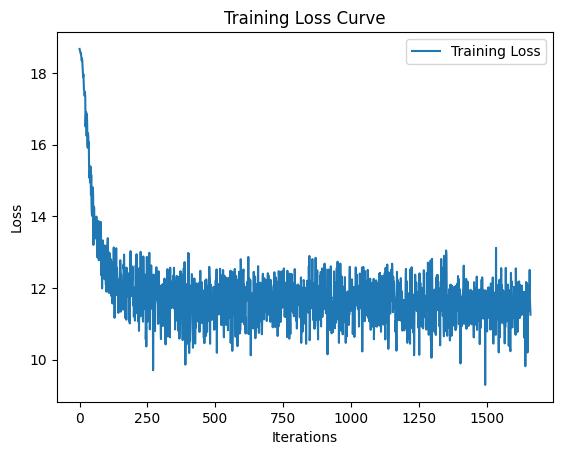

In [13]:
import matplotlib.pyplot as plt

# Plot the loss curve
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()


# ***EBS (Emotion Beam Search) algorithm to generate music segments***

**Using Transformer to generate music segment**

In [14]:
!pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 71.0 MB/s eta 0:00:00:00:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.9 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=78c6295c239ed5a18cad6f2d7fdd0e589f45fc860e218cda98946cf645418225
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker, which is not installed.
cudf 23.8.0 requir

In [15]:
import torch
from gensim.models import Word2Vec
import pandas as pd
import pdb
from collections import Counter
import argparse
from torch.autograd import Variable
from queue import PriorityQueue
import operator
import pretty_midi
# from Transformer_cls import TransformerClassifier
# from Transformer_generator import myTransformer, Transformer_seq2seq
from random import randint

In [23]:
# -*- coding: utf-8 -*-
# save np.load
# np_load_old = np.load

# # modify the default parameters of np.load
# np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# parser = argparse.ArgumentParser()
# parser.add_argument('--seqlen', type=int, default=50)
# parser.add_argument('--lyc2vec', type=int, default=128)
# parser.add_argument('--outlen', type=int, default=30)
# parser.add_argument('--b1', type=int, default=3)
# parser.add_argument('--b2', type=int, default=3)
# parser.add_argument('--b3', type=int, default=5)
# parser.add_argument('--emotion', default='')
# parser.add_argument('--output_num', type=int, default=1)
# args = parser.parse_args()

class Args:
    seqlen = 50
    lyc2vec = 128
    outlen = 30
    b1 = 3
    b2 = 3
    b3 = 5
    emotion = ''
    output_num = 1

# Parse command line arguments
args = Args()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

syll_model_path = '/kaggle/input/skip-gram-lyric-encoders/syllEncoding_skipgram_dim_'+str(args.lyc2vec)+'.bin'
word_model_path = '/kaggle/input/skip-gram-lyric-encoders/wordLevelEncoder_skipgram_dim_'+str(args.lyc2vec)+'.bin'
syllModel = Word2Vec.load(syll_model_path)
wordModel = Word2Vec.load(word_model_path)

seqlen = args.seqlen
lyc2vec = args.lyc2vec

generator_file = '/kaggle/working/Transformer_generator_seqlen_50_embed_128_epoch_0.pkl'
#generator_file = 'Transformer_generator_iter_1000_epoch_0.pkl'
#generator_file = 'saved_model/'+'Transformer_generator_'+'seqlen_'+str(seqlen)+'_embed_'+str(lyc2vec)+'_epoch_59.pkl'
binary_clf_file = '/kaggle/working/Transformer_datasetlen_'+str(seqlen)+'_fold_0_clf.pkl'

word_vocabulary_file = '/kaggle/input/saved-model/word_vocabulary.npy'
word_vocabulary = np.load(word_vocabulary_file)
word_vocabulary = word_vocabulary.item()
    
syllable_vocabulary_file = '/kaggle/input/saved-model/syllable_vocabulary.npy'
syllable_vocabulary = np.load(syllable_vocabulary_file)
syllable_vocabulary = syllable_vocabulary.item()
    
music_vocabulary_file = '/kaggle/input/saved-model/music_vocabulary_'+str(seqlen)+'.npy'
music_vocabulary = np.load(music_vocabulary_file)
music_vocabulary = music_vocabulary.item()
music_index2note = [x for x in music_vocabulary.keys()]
Ge_lyric_vocabulary = syllModel.wv.key_to_index

len_syllable_vocabulary = len(syllable_vocabulary)
len_word_vocabulary = len(word_vocabulary)
len_music_vocabulary = len(music_vocabulary)
len_Ge_lyric_vocabulary = len(Ge_lyric_vocabulary)

binary_clf = TransformerClassifier(input_txt_size=118, input_mus_size=10, nhead=8, num_layers=6, num_classes=2, syllable_vocabulary=syllable_vocabulary, music_vocabulary=music_vocabulary)
binary_clf.load_state_dict(torch.load(binary_clf_file))

transformer_model = myTransformer(d_model=lyc2vec*2, nhead=16, num_encoder_layers=12, num_decoder_layers=12, batch_first=True)
generator = Transformer_seq2seq(transformer_model=transformer_model, dim = lyc2vec*2, lyric_vocabulary=Ge_lyric_vocabulary, music_vocabulary=music_vocabulary)
generator.load_state_dict(torch.load(generator_file))

generator = generator.to(device)
binary_clf = binary_clf.to(device)

softmax = torch.nn.Softmax(dim=0)

def create_midi_pattern_from_discretized_data(discretized_sample):
    new_midi = pretty_midi.PrettyMIDI()
    voice = pretty_midi.Instrument(1)  # It's here to change the used instruments !
    tempo = 120
    ActualTime = 0  # Time since the beginning of the song, in seconds
    for i in range(0,len(discretized_sample)):
        length = discretized_sample[i][1] * 60 / tempo  # Conversion Duration to Time
        if i < len(discretized_sample) - 1:
            gap = discretized_sample[i + 1][2] * 60 / tempo
        else:
            gap = 0  # The Last element doesn't have a gap
        note = pretty_midi.Note(velocity=100, pitch=int(discretized_sample[i][0]), start=ActualTime,
                                end=ActualTime + length)
        voice.notes.append(note)
        ActualTime += length + gap  # Update of the time

    new_midi.instruments.append(voice)

    return new_midi

def Embedding_lyrics(lyric, syllModel, wordModel):
    lyric_input = torch.zeros((len(lyric), lyc2vec*2), dtype = torch.float64)
    txt_len = 0
    for i in range(len(lyric)):
        word = lyric[i][0]
        if word in wordModel.wv.index_to_key:
            word2Vec = wordModel.wv[word]
        else:
            for k in wordModel.wv.index_to_key:
                if word in k:
                    word2Vec = wordModel.wv[k]

        if word in syllModel.wv.index_to_key:
            syll2Vec = syllModel.wv[word]
        else:
            continue        

        syllWordVec = np.concatenate((word2Vec,syll2Vec))
        lyric_input[txt_len] = torch.from_numpy(syllWordVec)
        txt_len += 1
    return lyric_input.type(torch.float32)

def compute_emotion_score(classifier, emotion, EBS_sets, candidate_pairs, b3):
    new_EBS_sets = []
    if not classifier:
        for i in range(len(EBS_sets)):
            lyric = EBS_sets[i][0]
            melody = EBS_sets[i][1]
            pair = candidate_pairs[i][randint(0, len(candidate_pairs[i])-1)]
            lyric.append([pair[0]])
            melody.append(pair[1])
            new_EBS_sets.append((lyric, melody, 0.5))
        return new_EBS_sets
    else:
        classifier.eval()
        if emotion in ['negative', 'positive']:
            label=['negative', 'positive'].index(emotion)
        for i in range(len(EBS_sets)):
            lyric = EBS_sets[i][0]
            melody = EBS_sets[i][1]
            pairs = candidate_pairs[i]
            for pair in pairs:
                new_lyric = lyric + [[pair[0]]]
                txt = []
                for syll in new_lyric:
                    txt.append(syllable_vocabulary[syll[0]])
                txt = torch.Tensor(txt)
                txt = txt.type(torch.int64)
                txt = Variable(torch.unsqueeze(txt, dim=0).to(device))
                new_mus = melody+[pair[1]]
                mus = torch.Tensor(new_mus)
                mus = mus.type(torch.int64)
                mus = Variable(torch.unsqueeze(mus, dim=0).to(device))

                output = classifier(txt, mus)
                score = softmax(output.squeeze(0))[label]
                new_EBS_sets.append((new_lyric, new_mus, score.item()))

        new_EBS_sets = sorted(new_EBS_sets, reverse = True, key = lambda x:x[2])
        return new_EBS_sets[:b3]

def emotional_beam_search(seed_lyric, generator, classifier, outlen, b1, b2, b3):
    seed_len = len(seed_lyric)
    generator.eval()
    if classifier is not None:
        classifier.eval()

    seed_music = [randint(0, len_music_vocabulary-1)]
    for i in range(seed_len-1):
        lyric_input = seed_lyric[:(i+1)]
        lyric_input = Embedding_lyrics(lyric_input, syllModel, wordModel)
        lyric_input = torch.unsqueeze(lyric_input, dim=0)
        lyric_input = lyric_input.to(device)

        music_input = seed_music[:(i+1)]
        music_input = torch.Tensor(music_input).type(torch.int64)
        music_input = torch.unsqueeze(music_input, dim=0).to(device)

        en_pred, de_pred = generator(lyric_input, music_input)

        de_pred = torch.squeeze(de_pred, dim=0)
        predict = de_pred[-1]
        next_music = torch.argmax(predict)
        next_music = int(next_music.item())
        seed_music.append(next_music)

    EBS_sets = [(seed_lyric, seed_music, 0.5)]
    while True:
        candidate_pairs = []
        for m in EBS_sets:
            lyric_input = m[0]
            lyric_input = Embedding_lyrics(lyric_input, syllModel, wordModel)
            lyric_input = torch.unsqueeze(lyric_input, dim=0)
            lyric_input = lyric_input.to(device)

            music_input = m[1]
            music_input = torch.Tensor(music_input).type(torch.int64)
            music_input = torch.unsqueeze(music_input, dim=0).to(device)

            en_pred, de_pred = generator(lyric_input, music_input)

            en_pred = torch.squeeze(en_pred, dim=0)
            en_pred = en_pred[-1]
            en_pred = softmax(en_pred)

            de_pred = torch.squeeze(de_pred, dim=0)
            de_pred = de_pred[-1]
            de_pred = softmax(de_pred)

            seen_music = set(m[1])
            seen_syll = set()

            for m0 in m[0]:
                seen_syll.add(Ge_lyric_vocabulary[m0[0]])
            en_pred[list(seen_syll)] *= 0.0
            de_pred[list(seen_music)] *= 0.15
            

            log_prob_lyric, indexes_lyric = torch.topk(en_pred,b1,dim=0)
            log_prob_music, indexes_music = torch.topk(de_pred,b2,dim=0)
            
            m_pairs = []
            for i in range(b1):
                for j in range(b2):
                    syl = syllModel.wv.index_to_key[indexes_lyric[i].item()]
                    mel = int(indexes_music[j].item())
                    m_pairs.append((syl, mel))
            candidate_pairs.append(m_pairs)

        EBS_sets = compute_emotion_score(classifier, args.emotion, EBS_sets, candidate_pairs, b3)

        if EBS_sets[-1][2] > 0.9 and len(EBS_sets[0][0]) > 22:
            break
        elif len(EBS_sets[0][0]) > outlen:
            break

    for i in range(args.output_num):
        lyric_i = EBS_sets[i][0]
        score_i = EBS_sets[i][2]
        music_i = []
        for idx in EBS_sets[i][1]:
            music_note = music_index2note[idx]
            music_note = music_note.split('^')
            pitch = float(music_note[0][2:])
            duration = float(music_note[1][2:])
            rest = float(music_note[2][2:])
            music_i.append(np.array([pitch, duration, rest]))
        print(lyric_i, music_i, score_i)
        midi_pattern = create_midi_pattern_from_discretized_data(music_i)
        destination = args.emotion+str(i)+'.mid'
        midi_pattern.write(destination)
    return

if args.emotion in ['positive', 'negative']:
    classifier = binary_clf
else:
    classifier = None

seed_lyric0 = [['I'], ['give'], ['you'], ['my']]
seed_lyric1 = [['but'], ['when'], ['you'], ['told'], ['me']]
seed_lyric2 = [['if'], ['I'], ['was'], ['your'], ['man']]
seed_lyric3 = [['I'], ['have'], ['a'], ['dream']]
seed_lyric4 = [['when'], ['I'], ['got'], ['the']]

seed_lyric = [['I'], ['give'], ['you'], ['my']]
emotional_beam_search(seed_lyric2, generator, classifier, outlen = args.outlen, b1=args.b1, b2=args.b2, b3=args.b3)

[['if'], ['I'], ['was'], ['your'], ['man'], ['And'], ['she'], ['said'], ['But'], ['when'], ['you'], ['just'], ['a'], ['lone'], ['and'], ['me'], ['but'], ['my'], ['life'], ['is'], ['so'], ['much'], ['You'], ['were'], ['the'], ['time'], ['in'], ['an'], ['o'], ['u'], ['Oh']] [array([62.,  3., 16.]), array([84.,  1.,  0.]), array([84.,  1.,  0.]), array([84.,  1.,  0.]), array([84.,  1.,  0.]), array([84.,  2.,  0.]), array([82.,  1.,  0.]), array([79.,  1.,  0.]), array([86.,  1.,  0.]), array([81.,  1.,  0.]), array([84.,  1.,  0.]), array([84.,  1.,  0.]), array([84. ,  0.5,  0. ]), array([79. ,  0.5,  0. ]), array([79.  ,  0.25,  0.  ]), array([81. ,  0.5,  0. ]), array([84.,  1.,  0.]), array([84.,  1.,  0.]), array([82. ,  0.5,  0. ]), array([81. ,  1.5,  0. ]), array([79.,  1.,  1.]), array([84.,  1.,  0.]), array([83.,  1.,  0.]), array([86. ,  0.5,  0. ]), array([81.,  1.,  0.]), array([81.,  2.,  0.]), array([84.,  1.,  0.]), array([81.  ,  0.25,  0.  ]), array([81.,  1.,  0.]), 

**Using GRU (Gated Recurrent Unit) to generate music**

In [ ]:
import torch
from gensim.models import Word2Vec
import pandas as pd
import pdb
from collections import Counter
import argparse
from torch.autograd import Variable
from queue import PriorityQueue
import operator
import pretty_midi
from LSTM_cls import LSTMClassifier
from GRU_generator import Encoder, Decoder, Seq2Seq
from random import randint

In [21]:
# -*- coding: utf-8 -*-


# # save np.load
# np_load_old = np.load

# # modify the default parameters of np.load
# np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# parser = argparse.ArgumentParser()
# parser.add_argument('--seqlen', type=int, default=50)
# parser.add_argument('--lyc2vec', type=int, default=128)
# parser.add_argument('--outlen', type=int, default=30)
# parser.add_argument('--b1', type=int, default=3)
# parser.add_argument('--b2', type=int, default=3)
# parser.add_argument('--b3', type=int, default=5)
# parser.add_argument('--emotion', default='positive')
# parser.add_argument('--output_num', type=int, default=1)
# args = parser.parse_args()

class Args:
    seqlen = 50
    lyc2vec = 128
    outlen = 50
    b1 = 3
    b2 = 3
    b3 = 5
    emotion = 'positive'
    output_num = 1

# Parse command line arguments
args = Args()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

syll_model_path = '/kaggle/input/skip-gram-lyric-encoders/syllEncoding_skipgram_dim_'+str(args.lyc2vec)+'.bin'
word_model_path = '/kaggle/input/skip-gram-lyric-encoders/wordLevelEncoder_skipgram_dim_'+str(args.lyc2vec)+'.bin'
syllModel = Word2Vec.load(syll_model_path)
wordModel = Word2Vec.load(word_model_path)

seqlen = args.seqlen
lyc2vec = args.lyc2vec

generator_file = '/kaggle/working/GRU_generator_seqlen_50_embed_128_epoch_0.pkl'
#generator_file = 'saved_model/'+'GRU_generator_'+'seqlen_'+str(seqlen)+'_embed_'+str(lyc2vec)+'_epoch_59.pkl'
binary_clf_file = '/kaggle/working/LSTM_datasetlen_'+str(seqlen)+'_fold_0_clf.pkl'

word_vocabulary_file = '/kaggle/input/saved-model/word_vocabulary.npy'
word_vocabulary = np.load(word_vocabulary_file)
word_vocabulary = word_vocabulary.item()
    
syllable_vocabulary_file = '/kaggle/input/saved-model/syllable_vocabulary.npy'
syllable_vocabulary = np.load(syllable_vocabulary_file)
syllable_vocabulary = syllable_vocabulary.item()
    
music_vocabulary_file = '/kaggle/input/saved-model/music_vocabulary_'+str(seqlen)+'.npy'
music_vocabulary = np.load(music_vocabulary_file)
music_vocabulary = music_vocabulary.item()

music_index2note = [x for x in music_vocabulary.keys()]

Ge_lyric_vocabulary = syllModel.wv.key_to_index

len_syllable_vocabulary = len(syllable_vocabulary)
len_word_vocabulary = len(word_vocabulary)
len_music_vocabulary = len(music_vocabulary)
len_Ge_lyric_vocabulary = len(Ge_lyric_vocabulary)

binary_clf = LSTMClassifier(input_txt_size=128, input_mus_size=10, hidden_size=256, num_layers=6, num_classes=2, syllable_vocabulary=syllable_vocabulary, music_vocabulary=music_vocabulary)
binary_clf.load_state_dict(torch.load(binary_clf_file))

encoder = Encoder(input_size=lyc2vec*2, hidden_size=256, num_layers=4, vocabulary=Ge_lyric_vocabulary)
decoder = Decoder(embedding_dim=100, hidden_size=256, num_layers=4, vocabulary=music_vocabulary)
generator = Seq2Seq(encoder, decoder)
generator.load_state_dict(torch.load(generator_file))

generator = generator.to(device)
binary_clf = binary_clf.to(device)

softmax = torch.nn.Softmax(dim=0)

def create_midi_pattern_from_discretized_data(discretized_sample):
    new_midi = pretty_midi.PrettyMIDI()
    voice = pretty_midi.Instrument(1)  # It's here to change the used instruments !
    tempo = 120
    ActualTime = 0  # Time since the beginning of the song, in seconds
    for i in range(0,len(discretized_sample)):
        length = discretized_sample[i][1] * 60 / tempo  # Conversion Duration to Time
        if i < len(discretized_sample) - 1:
            gap = discretized_sample[i + 1][2] * 60 / tempo
        else:
            gap = 0  # The Last element doesn't have a gap
        note = pretty_midi.Note(velocity=100, pitch=int(discretized_sample[i][0]), start=ActualTime,
                                end=ActualTime + length)
        voice.notes.append(note)
        ActualTime += length + gap  # Update of the time

    new_midi.instruments.append(voice)

    return new_midi

def Embedding_lyrics(lyric, syllModel, wordModel):
    lyric_input = torch.zeros((len(lyric), lyc2vec*2), dtype = torch.float64)
    txt_len = 0
    for i in range(len(lyric)):
        word = lyric[i][0]
        if word in wordModel.wv.index_to_key:
            word2Vec = wordModel.wv[word]
        else:
            for k in wordModel.wv.index_to_key:
                if word in k:
                    word2Vec = wordModel.wv[k]

        if word in syllModel.wv.index_to_key:
            syll2Vec = syllModel.wv[word]
        else:
            continue        

        syllWordVec = np.concatenate((word2Vec,syll2Vec))
        lyric_input[txt_len] = torch.from_numpy(syllWordVec)
        txt_len += 1
    return lyric_input.type(torch.float32)

def compute_emotion_score(classifier, emotion, EBS_sets, candidate_pairs, b3):
    new_EBS_sets = []
    if not classifier:
        for i in range(len(EBS_sets)):
            lyric = EBS_sets[i][0]
            melody = EBS_sets[i][1]
            pair = candidate_pairs[i][randint(0, len(candidate_pairs[i])-1)]
            lyric.append([pair[0]])
            melody.append(pair[1])
            new_EBS_sets.append((lyric, melody, 0.5))
        return new_EBS_sets
    else:
        classifier.eval()
        if emotion in ['negative', 'positive']:
            label=['negative', 'positive'].index(emotion)
        for i in range(len(EBS_sets)):
            lyric = EBS_sets[i][0]
            melody = EBS_sets[i][1]
            pairs = candidate_pairs[i]
            for pair in pairs:
                new_lyric = lyric + [[pair[0]]]
                txt = []
                for syll in new_lyric:
                    txt.append(syllable_vocabulary[syll[0]])
                txt = torch.Tensor(txt)
                txt = txt.type(torch.int64)
                txt = Variable(torch.unsqueeze(txt, dim=0).to(device))
                new_mus = melody+[pair[1]]
                mus = torch.Tensor(new_mus)
                mus = mus.type(torch.int64)
                mus = Variable(torch.unsqueeze(mus, dim=0).to(device))

                output = classifier(txt, mus)
                score = softmax(output.squeeze(0))[label]
                new_EBS_sets.append((new_lyric, new_mus, score.item()))

        new_EBS_sets = sorted(new_EBS_sets, reverse = True, key = lambda x:x[2])
        return new_EBS_sets[:b3]

def emotional_beam_search(seed_lyric, generator, classifier, outlen, b1, b2, b3):
    seed_len = len(seed_lyric)
    generator.eval()
    if classifier is not None:
        classifier.eval()

    seed_music = [randint(0, 100)]
    for i in range(seed_len-1):
        lyric_input = seed_lyric[:(i+1)]
        lyric_input = Embedding_lyrics(lyric_input, syllModel, wordModel)
        lyric_input = torch.unsqueeze(lyric_input, dim=1)
        lyric_input = lyric_input.to(device)

        music_input = seed_music[:(i+1)]
        music_input = torch.Tensor(music_input).type(torch.int64)
        music_input = torch.unsqueeze(music_input, dim=1).to(device)

        en_state_h = encoder.init_state(1)
        en_state_h = Variable(en_state_h.to(device))

        en_pred, de_pred, en_state_h = generator(lyric_input, music_input, en_state_h)
        en_state_h = en_state_h.detach()

        de_pred = torch.squeeze(de_pred, dim=1)
        predict = de_pred[-1]
        next_music = torch.argmax(predict)
        next_music = int(next_music.item())
        seed_music.append(next_music)

    EBS_sets = [(seed_lyric, seed_music, 0.5)]
    while True:
        candidate_pairs = []
        for m in EBS_sets:
            lyric_input = m[0]
            lyric_input = Embedding_lyrics(lyric_input, syllModel, wordModel)
            lyric_input = torch.unsqueeze(lyric_input, dim=1)
            lyric_input = lyric_input.to(device)

            music_input = m[1]
            music_input = torch.Tensor(music_input).type(torch.int64)
            music_input = torch.unsqueeze(music_input, dim=1).to(device)

            en_pred, de_pred, en_state_h = generator(lyric_input, music_input, en_state_h)
            en_state_h = en_state_h.detach()

            en_pred = torch.squeeze(en_pred, dim=1)
            en_pred = en_pred[-1]
            en_pred = softmax(en_pred)

            de_pred = torch.squeeze(de_pred, dim=1)
            de_pred = de_pred[-1]
            de_pred = softmax(de_pred)

            seen_music = set(m[1])
            seen_syll = set()

            for m0 in m[0]:
                seen_syll.add(Ge_lyric_vocabulary[m0[0]])
            en_pred[list(seen_syll)] *= 0.5
            de_pred[list(seen_music)] *= 0.9
            #for m1 in m[1]:
                #de_pred[m1] *= 0.8
            
            

            log_prob_lyric, indexes_lyric = torch.topk(en_pred,b1,dim=0)
            log_prob_music, indexes_music = torch.topk(de_pred,b2,dim=0)
            
            m_pairs = []
            for i in range(b1):
                for j in range(b2):
                    syl = syllModel.wv.index_to_key[indexes_lyric[i].item()]
                    mel = int(indexes_music[j].item())
                    m_pairs.append((syl, mel))
            candidate_pairs.append(m_pairs)

        EBS_sets = compute_emotion_score(classifier, args.emotion, EBS_sets, candidate_pairs, b3)

        if EBS_sets[-1][2] > 0.9 and len(EBS_sets[0][0]) > 22:
            break
        elif len(EBS_sets[0][0]) > outlen:
            break

    for i in range(args.output_num):
        lyric_i = EBS_sets[i][0]
        score_i = EBS_sets[i][2]
        music_i = []
        for idx in EBS_sets[i][1]:
            music_note = music_index2note[idx]
            music_note = music_note.split('^')
            pitch = float(music_note[0][2:])
            duration = float(music_note[1][2:])
            rest = float(music_note[2][2:])
            music_i.append(np.array([pitch, duration, rest]))
        print(lyric_i, music_i, score_i)
        midi_pattern = create_midi_pattern_from_discretized_data(music_i)
        destination = args.emotion+str(i)+'.mid'
        midi_pattern.write(destination)
    return



if args.emotion in ['positive', 'negative']:
    classifier = binary_clf
else:
    classifier = None

seed_lyric0 = [['I'], ['give'], ['you'], ['my']]
seed_lyric1 = [['but'], ['when'], ['you'], ['told'], ['me']]
seed_lyric2 = [['if'], ['I'], ['was'], ['your'], ['man']]
seed_lyric3 = [['I'], ['have'], ['a'], ['dream']]
seed_lyric4 = [['when'], ['I'], ['got'], ['the']]

seed_lyric = [['I'], ['give'], ['you'], ['my']]
emotional_beam_search(seed_lyric2, generator, classifier, outlen = args.outlen, b1=args.b1, b2=args.b2, b3=args.b3)

[['if'], ['I'], ['was'], ['your'], ['man'], ['a'], ['love'], ['the'], ['know'], ['to'], ['you'], ['and'], ['a'], ['be'], ['the'], ['I'], ['on'], ['the'], ['I'], ['I'], ['I'], ['can'], ['a']] [array([72.,  1.,  2.]), array([71.,  1.,  0.]), array([71.,  1.,  0.]), array([71.,  1.,  0.]), array([71.,  1.,  0.]), array([64.,  1.,  0.]), array([64.,  1.,  0.]), array([69.,  1.,  0.]), array([69.,  1.,  0.]), array([69.,  1.,  0.]), array([64.,  1.,  0.]), array([69.,  1.,  0.]), array([67.,  1.,  0.]), array([69.,  1.,  0.]), array([69.,  1.,  0.]), array([72.,  1.,  0.]), array([64.,  1.,  0.]), array([69.,  1.,  0.]), array([64.,  1.,  0.]), array([64.,  1.,  0.]), array([64.,  1.,  0.]), array([64.,  1.,  0.]), array([64.,  1.,  0.])] 0.9967580437660217
